# Automatic differentiation


**Note**: the code below requires autograd for computing the gradient of the logistic regression, which you can install from the command line by typing ```conda install --channel conda-forge autograd```. If this fails you can also load the full gradient expresion of the gradient from the first class.

In [3]:
import autograd.numpy as np # Thinly−wrapped numpy
from autograd import elementwise_grad

def f(x): # Define a function
    y = np.exp( - x )
    return (1.0 - y ) / ( 1.0 + y )


In [5]:

D_f = elementwise_grad(f) # Obtain gradient function
D2_f = elementwise_grad(D_f) # 2nd derivative
D3_f = elementwise_grad(D2_f) # 3rd derivative
D4_f = elementwise_grad(D3_f) # etc.
D5_f = elementwise_grad(D4_f)
D6_f = elementwise_grad(D5_f)


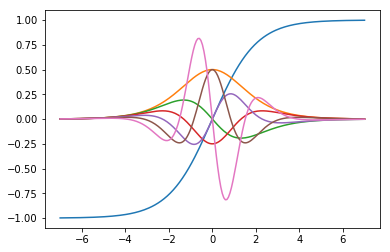

In [6]:
import matplotlib.pyplot as plt
x = np.linspace ( -7 , 7 , 200)
plt.plot(x , f(x))
plt.plot(x, D_f(x))
plt.plot(x, D2_f(x))
plt.plot(x, D3_f(x))
plt.plot(x, D4_f(x))
plt.plot(x, D5_f(x))
plt.plot(x, D6_f(x))
plt.show ()

In [7]:
"""Convolutional neural net on MNIST, modeled on 'LeNet-5',
http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf"""
from __future__ import absolute_import
from __future__ import print_function

import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy.signal
from autograd import grad
from builtins import range
import data_mnist

convolve = autograd.scipy.signal.convolve

class WeightsParser(object):
    """A helper class to index into a parameter vector."""
    def __init__(self):
        self.idxs_and_shapes = {}
        self.N = 0

    def add_weights(self, name, shape):
        start = self.N
        self.N += np.prod(shape)
        self.idxs_and_shapes[name] = (slice(start, self.N), shape)

    def get(self, vect, name):
        idxs, shape = self.idxs_and_shapes[name]
        return np.reshape(vect[idxs], shape)

def make_batches(N_total, N_batch):
    start = 0
    batches = []
    while start < N_total:
        batches.append(slice(start, start + N_batch))
        start += N_batch
    return batches

def logsumexp(X, axis, keepdims=False):
    max_X = np.max(X)
    return max_X + np.log(np.sum(np.exp(X - max_X), axis=axis, keepdims=keepdims))

def make_nn_funs(input_shape, layer_specs, L2_reg):
    parser = WeightsParser()
    cur_shape = input_shape
    for layer in layer_specs:
        N_weights, cur_shape = layer.build_weights_dict(cur_shape)
        parser.add_weights(layer, (N_weights,))

    def predictions(W_vect, inputs):
        """Outputs normalized log-probabilities.
        shape of inputs : [data, color, y, x]"""
        cur_units = inputs
        for layer in layer_specs:
            cur_weights = parser.get(W_vect, layer)
            cur_units = layer.forward_pass(cur_units, cur_weights)
        return cur_units

    def loss(W_vect, X, T):
        log_prior = -L2_reg * np.dot(W_vect, W_vect)
        log_lik = np.sum(predictions(W_vect, X) * T)
        return - log_prior - log_lik

    def frac_err(W_vect, X, T):
        return np.mean(np.argmax(T, axis=1) != np.argmax(pred_fun(W_vect, X), axis=1))

    return parser.N, predictions, loss, frac_err

class conv_layer(object):
    def __init__(self, kernel_shape, num_filters):
        self.kernel_shape = kernel_shape
        self.num_filters = num_filters

    def forward_pass(self, inputs, param_vector):
        # Input dimensions:  [data, color_in, y, x]
        # Params dimensions: [color_in, color_out, y, x]
        # Output dimensions: [data, color_out, y, x]
        params = self.parser.get(param_vector, 'params')
        biases = self.parser.get(param_vector, 'biases')
        conv = convolve(inputs, params, axes=([2, 3], [2, 3]), dot_axes = ([1], [0]), mode='valid')
        return conv + biases

    def build_weights_dict(self, input_shape):
        # Input shape : [color, y, x] (don't need to know number of data yet)
        self.parser = WeightsParser()
        self.parser.add_weights('params', (input_shape[0], self.num_filters)
                                          + self.kernel_shape)
        self.parser.add_weights('biases', (1, self.num_filters, 1, 1))
        output_shape = (self.num_filters,) + \
                       self.conv_output_shape(input_shape[1:], self.kernel_shape)
        return self.parser.N, output_shape

    def conv_output_shape(self, A, B):
        return (A[0] - B[0] + 1, A[1] - B[1] + 1)

class maxpool_layer(object):
    def __init__(self, pool_shape):
        self.pool_shape = pool_shape

    def build_weights_dict(self, input_shape):
        # input_shape dimensions: [color, y, x]
        output_shape = list(input_shape)
        for i in [0, 1]:
            assert input_shape[i + 1] % self.pool_shape[i] == 0, \
                "maxpool shape should tile input exactly"
            output_shape[i + 1] = input_shape[i + 1] / self.pool_shape[i]
        return 0, output_shape

    def forward_pass(self, inputs, param_vector):
        new_shape = inputs.shape[:2]
        for i in [0, 1]:
            pool_width = self.pool_shape[i]
            img_width = inputs.shape[i + 2]
            new_shape += (pool_width, img_width // pool_width)
        result = inputs.reshape(new_shape)
        return np.max(np.max(result, axis=2), axis=3)

class full_layer(object):
    def __init__(self, size):
        self.size = size

    def build_weights_dict(self, input_shape):
        # Input shape is anything (all flattened)
        input_size = np.prod(input_shape, dtype=int)
        self.parser = WeightsParser()
        self.parser.add_weights('params', (input_size, self.size))
        self.parser.add_weights('biases', (self.size,))
        return self.parser.N, (self.size,)

    def forward_pass(self, inputs, param_vector):
        params = self.parser.get(param_vector, 'params')
        biases = self.parser.get(param_vector, 'biases')
        if inputs.ndim > 2:
            inputs = inputs.reshape((inputs.shape[0], np.prod(inputs.shape[1:])))
        return self.nonlinearity(np.dot(inputs[:, :], params) + biases)

class tanh_layer(full_layer):
    def nonlinearity(self, x):
        return np.tanh(x)

class softmax_layer(full_layer):
    def nonlinearity(self, x):
        return x - logsumexp(x, axis=1, keepdims=True)

if __name__ == '__main__':
    # Network parameters
    L2_reg = 1.0
    input_shape = (1, 28, 28)
    layer_specs = [conv_layer((5, 5), 6),
                   maxpool_layer((2, 2)),
                   conv_layer((5, 5), 16),
                   maxpool_layer((2, 2)),
                   tanh_layer(120),
                   tanh_layer(84),
                   softmax_layer(10)]

    # Training parameters
    param_scale = 0.1
    learning_rate = 1e-3
    momentum = 0.9
    batch_size = 256
    num_epochs = 50

    # Load and process MNIST data
    print("Loading training data...")
    add_color_channel = lambda x : x.reshape((x.shape[0], 1, x.shape[1], x.shape[2]))
    one_hot = lambda x, K : np.array(x[:,None] == np.arange(K)[None, :], dtype=int)
    train_images, train_labels, test_images, test_labels = data_mnist.mnist()
    train_images = add_color_channel(train_images) / 255.0
    test_images  = add_color_channel(test_images)  / 255.0
    train_labels = one_hot(train_labels, 10)
    test_labels = one_hot(test_labels, 10)
    N_data = train_images.shape[0]

    # Make neural net functions
    N_weights, pred_fun, loss_fun, frac_err = make_nn_funs(input_shape, layer_specs, L2_reg)
    loss_grad = grad(loss_fun)

    # Initialize weights
    rs = npr.RandomState()
    W = rs.randn(N_weights) * param_scale

    # Check the gradients numerically, just to be safe
    # quick_grad_check(loss_fun, W, (train_images[:50], train_labels[:50]))

    print("    Epoch      |    Train err  |   Test error  ")
    def print_perf(epoch, W):
        test_perf  = frac_err(W, test_images, test_labels)
        train_perf = frac_err(W, train_images, train_labels)
        print("{0:15}|{1:15}|{2:15}".format(epoch, train_perf, test_perf))

    # Train with sgd
    batch_idxs = make_batches(N_data, batch_size)
    cur_dir = np.zeros(N_weights)

    for epoch in range(num_epochs):
        print_perf(epoch, W)
        for idxs in batch_idxs:
            grad_W = loss_grad(W, train_images[idxs], train_labels[idxs])
            cur_dir = momentum * cur_dir + (1.0 - momentum) * grad_W
            W -= learning_rate * cur_dir

Loading training data...
    Epoch      |    Train err  |   Test error  


KeyboardInterrupt: 